In [1]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az

In [2]:
df_hourly_max = pd.read_pickle('prcp_hourly_max.pkl')
df_X = pd.read_pickle('stations_xy.pkl')

In [3]:
params = {}

for station in df_hourly_max:

    GEV_hourly = GEVMLE_ts()
    GEV_hourly.fit(df_hourly_max[station].fillna(0.0))
    station_params = GEV_hourly.get_params()
    station_params['10y'] = GEV_hourly.return_level(10)
    station_params['100y'] = GEV_hourly.return_level(100)
    station_params['10yse'] = GEV_hourly.return_level_se(10).item()
    station_params['100yse'] = GEV_hourly.return_level_se(100).item()
    params[station] = station_params

pd.DataFrame(params).T

,mu,sigma,xi,10y,100y,10yse,100yse
BOS,0.743041,0.218308,0.082367,1.282793,1.964037,0.091115,0.318363
BDL,0.866210,0.326382,0.082323,1.673127,2.691466,0.140195,0.549130
JFK,0.984831,0.323643,0.141936,1.842901,3.085250,0.155777,0.609815
LGA,0.999008,0.340878,-0.017883,1.750878,2.504331,0.112338,0.321120
EWR,1.010923,0.313233,0.165943,1.865461,3.173123,0.161646,0.696984
PHL,1.087505,0.381774,-0.018358,1.929132,2.771611,0.123407,0.335926
ILG,1.023899,0.317822,0.159448,1.884261,3.181259,0.164271,0.735896


In [4]:
df_annual_max = df_hourly_max.groupby(lambda x:x.year).max()
df_annual_max.max(), df_annual_max.mean(), df_annual_max.std()

(station
 BOS    2.03
 BDL    2.38
 JFK    2.88
 LGA    2.44
 EWR    3.24
 PHL    2.84
 ILG    2.69
 dtype: float64,
 station
 BOS    0.888302
 BDL    1.083019
 JFK    1.223019
 LGA    1.190943
 EWR    1.249245
 PHL    1.299623
 ILG    1.261698
 dtype: float64,
 station
 BOS    0.313968
 BDL    0.450126
 JFK    0.504406
 LGA    0.432854
 EWR    0.493102
 PHL    0.488034
 ILG    0.473037
 dtype: float64)

In [5]:
station = 'JFK'

ts_hourly_max = df_hourly_max[station]
ts_annual_max = df_annual_max[station]

GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [6]:
GEV_hourly.return_level(100)

3.085250101547203

In [7]:
def gev_returnlevel(rp, μ, σ, ξ):
    p = 1.0 / rp
    return μ - (σ / ξ) * (1 - np.power(-np.log(1.0 - p), -ξ))

In [8]:
data =ts_annual_max.values

# return_periods = GEV_hourly._return_periods(n=50)
return_periods = np.logspace(0.01,2, num=100)
p = 1/return_periods

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=1.0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.5)
    ξ = pm.math.tanh(pm.Normal("ξ", mu=0, sigma=0.15))

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=data)
    # Return level
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))
    # z_p = pm.Deterministic("z_p", gev_returnlevel(return_periods, μ, σ, ξ))
    gev_returnlevel

Sampling: [gev, μ, ξ, σ]


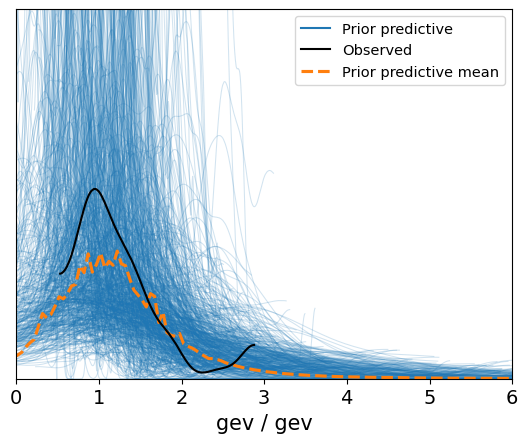

In [9]:
idata = pm.sample_prior_predictive(samples=1000, model=model)
az.plot_ppc(idata, group="prior")
ax = plt.gca()
ax.set_xlim([0, 6])
ax.set_ylim([0, 2]);

In [10]:
# az.plot_posterior(
#     idata, group="prior", var_names=["μ", "σ", "ξ"]
# );

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.


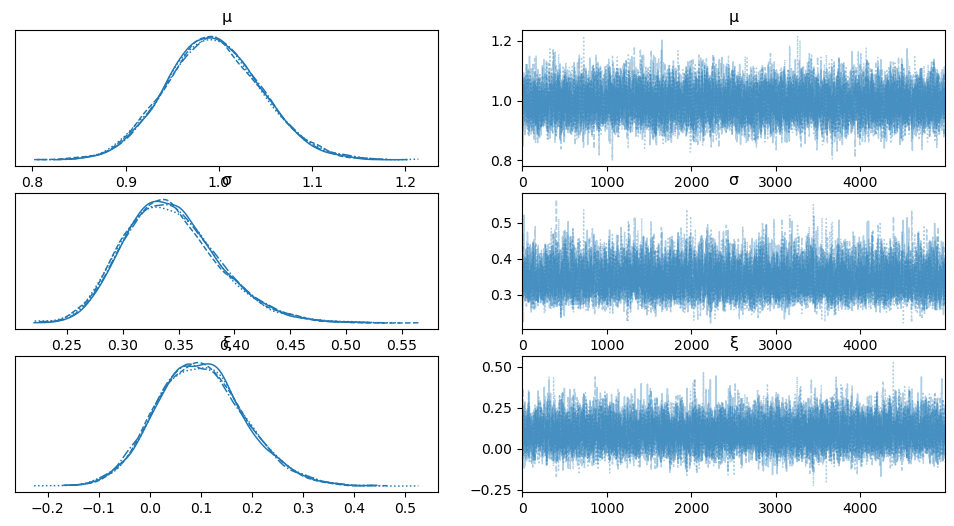

In [11]:
with model:
    trace = pm.sample(
        5000,
        # cores=4,
        # chains=4,
        # tune=2000,
        # initvals={"μ": -0.5, "σ": 1.0, "ξ": -0.1},
        target_accept=0.98,
    )
# add trace to existing idata object
idata.extend(trace)
az.plot_trace(idata, var_names=["μ", "σ", "ξ"]);

In [12]:
az.summary(idata,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.995,0.051,0.893,1.093,0.001,0.000,9371.0,10600.0,1.0
σ,0.344,0.043,0.269,0.432,0.000,0.000,8337.0,11397.0,1.0
ξ,0.100,0.086,-0.062,0.274,0.001,0.001,9235.0,10938.0,1.0


In [13]:
z_p_summary = az.summary(idata,var_names=["z_p"],hdi_prob= 0.95)
z_p_summary.index = return_periods

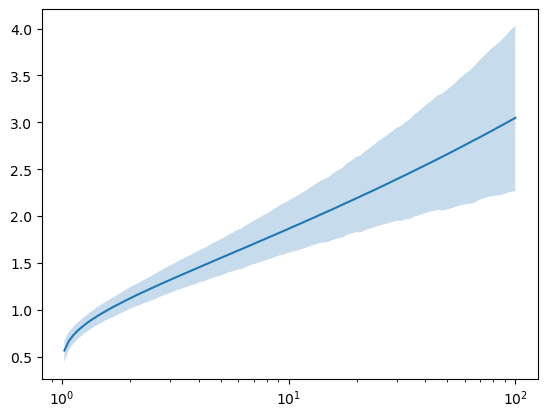

In [14]:
z_p_summary['mean'].plot()
plt.fill_between(z_p_summary.index,z_p_summary['hdi_2.5%'].values,z_p_summary['hdi_97.5%'].values,alpha=0.25)
plt.xscale("log")

In [15]:
GEV_hourly.return_level(100), GEV_hourly.return_level_se(100)

(3.085250101547203, array(0.60981525))

In [16]:
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [17]:
sample_cols = df_annual_max.columns
sample_cols = ['JFK','LGA','EWR']

df_X_y = df_annual_max[sample_cols].stack().to_frame('PRCP').join(df_X)
X_ = df_X_y[['X','Y']].to_numpy()
y_ = df_X_y['PRCP'].to_numpy()
X_.shape, y_.shape

((159, 2), (159,))

In [18]:
f = 


SyntaxError: invalid syntax (2391194814.py, line 1)

In [19]:
#https://betanalpha.github.io/assets/case_studies/gp_part3/part3.html#4_adding_an_informative_prior_for_the_length_scale

coords = {
    "cov_params": ["mu","sigma"],
}

with pm.Model(coords=coords) as gp_model:
    # ℓ = pm.InverseGamma("ℓ", mu = 100.0, sigma = 20.0, dims = "cov_params")
    # ℓ = pm.InverseGamma("ℓ", mu = 100.0, sigma = 20.0)
    ℓ = pm.InverseGamma("ℓ", mu = 20.0, sigma = 50.0)
    # η = pm.Gamma("η", alpha=1.0, beta=5.0, dims = "cov_params")
    η = pm.Gamma("η", mu=1.0, sigma=2.0, dims = "cov_params")

    cov_μ = η[0]**2 * pm.gp.cov.Exponential(input_dim = 2, ls = ℓ)
    gp_μ = pm.gp.Latent(cov_func=cov_μ)
    # μ_group = pm.Normal("μ_group", mu=1.0, sigma=5.0)
    # μ = pm.Deterministic("μ", μ_group + gp_μ.prior("μ_gp", X=X_))
    # μ_group = pm.Normal("μ_group", mu=1.0, sigma=5.0)
    μ =  gp_μ.prior("μ_gp", X=X_)

    cov_σ_log = η[1]**2 * pm.gp.cov.Exponential(input_dim = 2, ls = ℓ)
    gp_σ_log = pm.gp.Latent(cov_func=cov_σ_log)
    σ_log = gp_σ_log.prior("σ_log", X=X_)
    # σ_log_group = pm.Normal("σ_log_group", mu=-1.0, sigma=5.0)
    # σ = pm.Deterministic("σ", pm.math.exp(σ_log_group + σ_log))
    σ = pm.Deterministic("σ", pm.math.exp( σ_log))

    # cov_ξ = η[2]**2 * pm.gp.cov.ExpQuad(input_dim = 2, ls = ℓ[2])
    # gp_ξ = pm.gp.Latent(cov_func=cov_ξ)
    # ξ = pm.math.tanh(gp_ξ.prior("ξ", X=X_))

    ξ = pm.math.tanh(pm.Normal("ξ", mu=0, sigma=0.15))

    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y_)

    # vi_approx = pm.fit()
    # gp_trace = vi_approx.sample(1000)

    gp_trace = pm.sample(1000, 
        tune = 1000, 
        chains = 2, 
        cores = 2, 
        target_accept = 0.98,
        nuts_sampler = "numpyro"
        )

/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.870625
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  3:34:27.201205
Transforming variables...
Transformation time =  0:00:05.245473


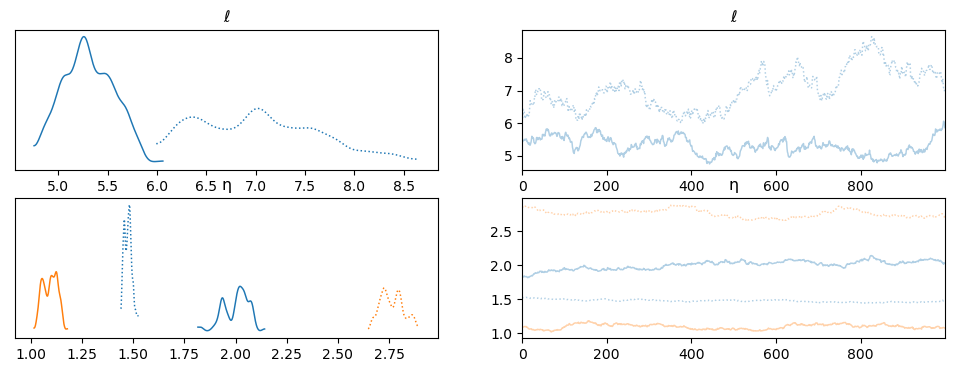

In [20]:
az.plot_trace(gp_trace, var_names=["ℓ", "η"]);

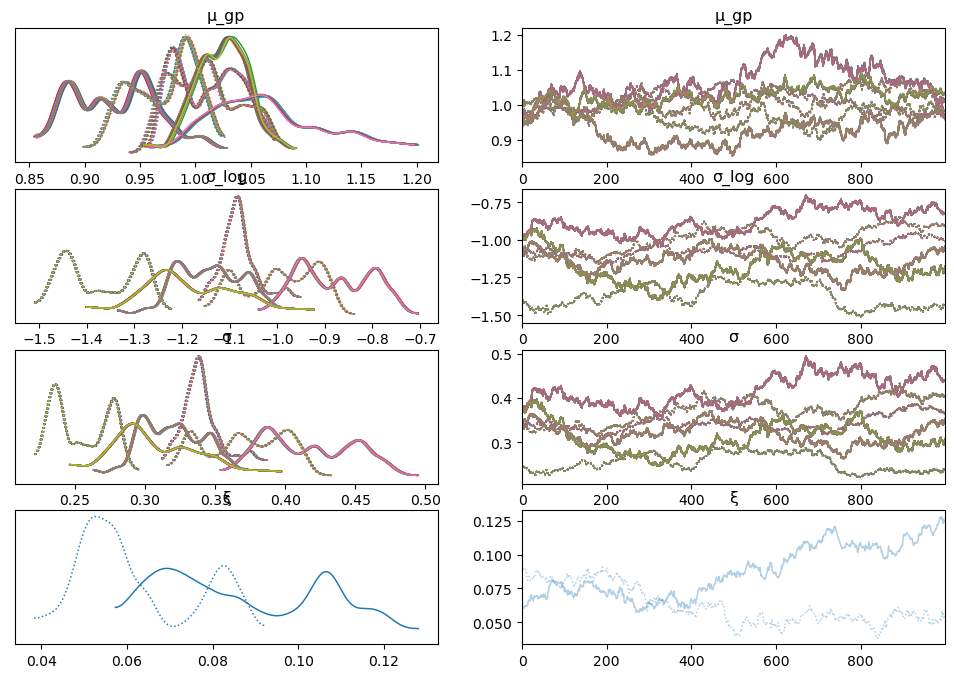

In [22]:
az.plot_trace(gp_trace, var_names=["μ_gp","σ_log", "σ", "ξ"]);

In [23]:
az.summary(gp_trace,var_names=["ℓ", "η"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ,6.178,0.989,4.802,7.885,0.664,0.550,3.0,25.0,2.21
η[mu],1.739,0.268,1.444,2.078,0.187,0.158,2.0,24.0,2.39
η[sigma],1.929,0.836,1.032,2.854,0.588,0.497,3.0,39.0,1.97


In [ ]:
az.summary(gp_trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95).sort_values('r_hat')

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],1.001,0.034,0.936,1.071,0.001,0.000,2423.0,1585.0,1.0
σ[57],0.338,0.025,0.291,0.387,0.000,0.000,2468.0,1317.0,1.0
σ[56],0.336,0.026,0.287,0.390,0.001,0.000,1615.0,1395.0,1.0
σ[55],0.340,0.025,0.297,0.394,0.001,0.000,2292.0,1428.0,1.0
σ[54],0.338,0.025,0.292,0.387,0.000,0.000,2466.0,1336.0,1.0
...,...,...,...,...,...,...,...,...,...
μ[103],0.999,0.035,0.931,1.069,0.001,0.001,2185.0,1280.0,1.0
μ[102],1.001,0.034,0.936,1.071,0.001,0.000,2416.0,1599.0,1.0
μ[101],1.006,0.034,0.945,1.079,0.001,0.001,2029.0,1668.0,1.0
μ[108],1.001,0.034,0.935,1.070,0.001,0.000,2384.0,1585.0,1.0


In [ ]:
X_sample = df_X.loc[sample_cols][['X','Y']].to_numpy()
# X_sample = df_X[['X','Y']].to_numpy()

pred_vars = ["mu_pred1", "sigma_log_pred1", "xi_pred1","z_p_101","z_p_1001"]
pred_vars = ["mu_pred3", "mu_pred_gp3", "sigma_log_pred3","sigma_pred3", "ξ"]
jitter = 1e-6

with gp_model:
    mu_pred = pm.Deterministic(pred_vars[0], μ_group + gp_μ.conditional(pred_vars[1], Xnew=X_sample, jitter=jitter))
    sigma_log_pred = gp_σ_log.conditional(pred_vars[2], Xnew=X_sample, jitter=jitter)
    sigma_pred = pm.Deterministic(pred_vars[3], pm.math.exp(σ_log_group+sigma_log_pred))

    posterior_pred = pm.sample_posterior_predictive(gp_trace, var_names=pred_vars)

Sampling: [mu_pred_gp3, sigma_log_pred3, ξ]
INFO:pymc.sampling.forward:Sampling: [mu_pred_gp3, sigma_log_pred3, ξ]


In [ ]:
pred_xi = az.extract(posterior_pred.posterior_predictive, var_names="ξ")
pred_mu = az.extract(posterior_pred.posterior_predictive, var_names="mu_pred3")
pred_sigma = az.extract(posterior_pred.posterior_predictive, var_names="sigma_pred3")

In [ ]:
gev_returnlevel(10.0,pred_mu.to_numpy(),pred_sigma.to_numpy(),pred_xi.to_numpy()).mean(axis=1)
# gev_returnlevel(100.0,pred_mu.to_numpy(),pred_sigma.to_numpy(),pred_xi.to_numpy()).mean(axis=1)

array([1.77841067, 1.77999368, 1.77839004])

In [ ]:
az.extract(posterior_pred.posterior_predictive, var_names="mu_pred2").mean(axis=1)
# az.extract(posterior_pred.posterior_predictive, var_names="xi_pred").mean(axis=1)
# az.extract(posterior_pred.posterior_predictive, var_names="z_p_10").mean(axis=1)
# az.extract(posterior_pred.posterior_predictive, var_names="z_p_100").mean(axis=1)
# az.extract(posterior_pred.posterior_predictive, var_names="xi_pred1").mean(axis=1)
# az.extract(posterior_pred.posterior_predictive, var_names="z_p_10").mean(axis=1)

<xarray.DataArray 'mu_pred2' (mu_pred2_dim_2: 3)>
array([0.99477069, 0.98669524, 1.02285231])
Coordinates:
  * mu_pred2_dim_2  (mu_pred2_dim_2) int64 0 1 2

In [ ]:
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["μ"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["z_p_10"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["z_p_100"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["σ"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["ξ"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["η"]).mean()
# az.summary(gp_trace,hdi_prob= 0.95,var_names=["ℓ"]).mean()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean          -0.247690
sd             0.335429
hdi_2.5%      -0.982164
hdi_97.5%      0.282722
mcse_mean      0.010714
mcse_sd        0.007571
ess_bulk     935.854447
ess_tail     942.738544
r_hat               NaN
dtype: float64

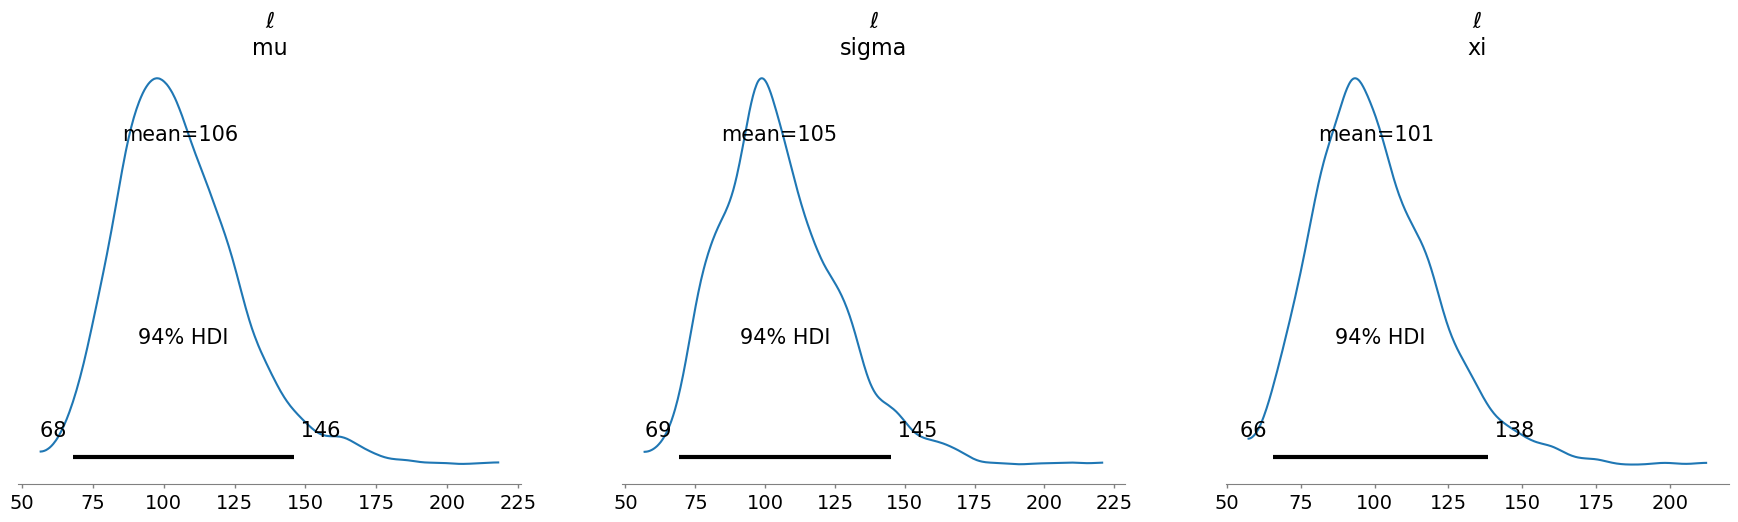

In [ ]:
az.plot_posterior(
    gp_trace, group="posterior", var_names=["ℓ"]
);

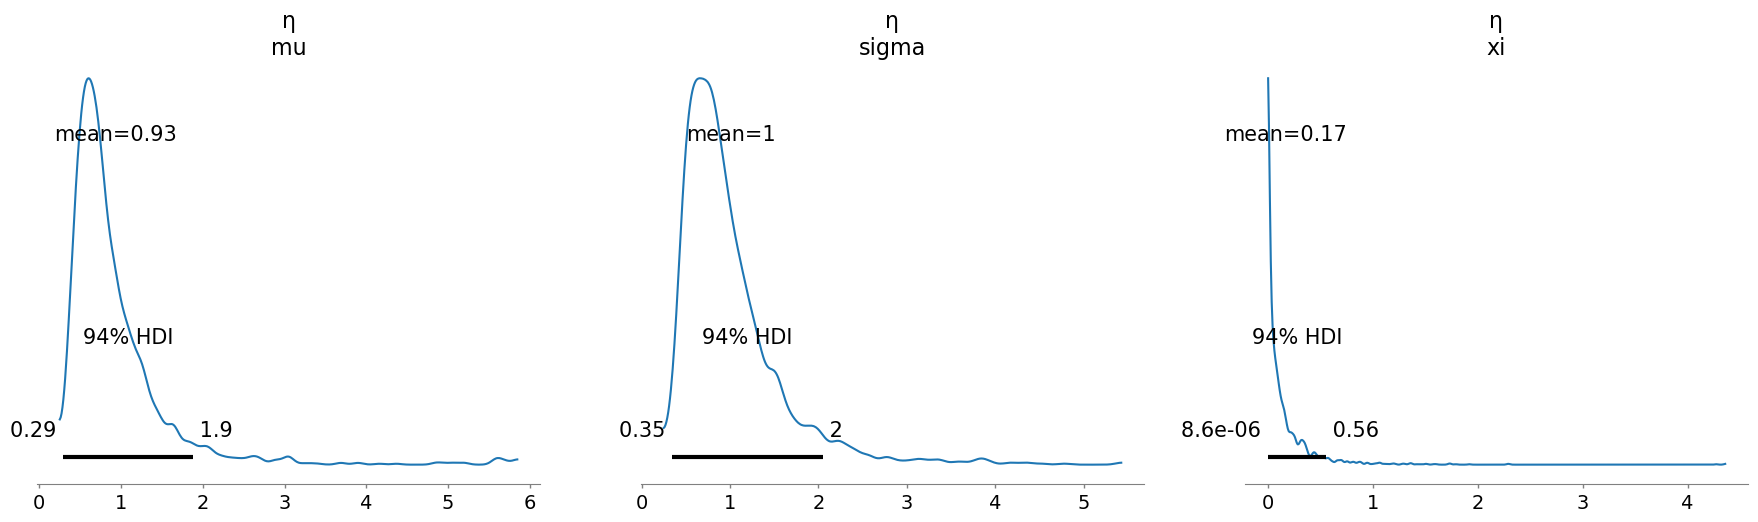

In [ ]:
az.plot_posterior(
    gp_trace, group="posterior", var_names=["η"]
);

Sampling: [gev, mu_pred_gp3, sigma_log_pred3, η, μ_gp_rotated_, μ_group, ξ, σ_log_group, σ_log_rotated_, ℓ]
INFO:pymc.sampling.forward:Sampling: [gev, mu_pred_gp3, sigma_log_pred3, η, μ_gp_rotated_, μ_group, ξ, σ_log_group, σ_log_rotated_, ℓ]


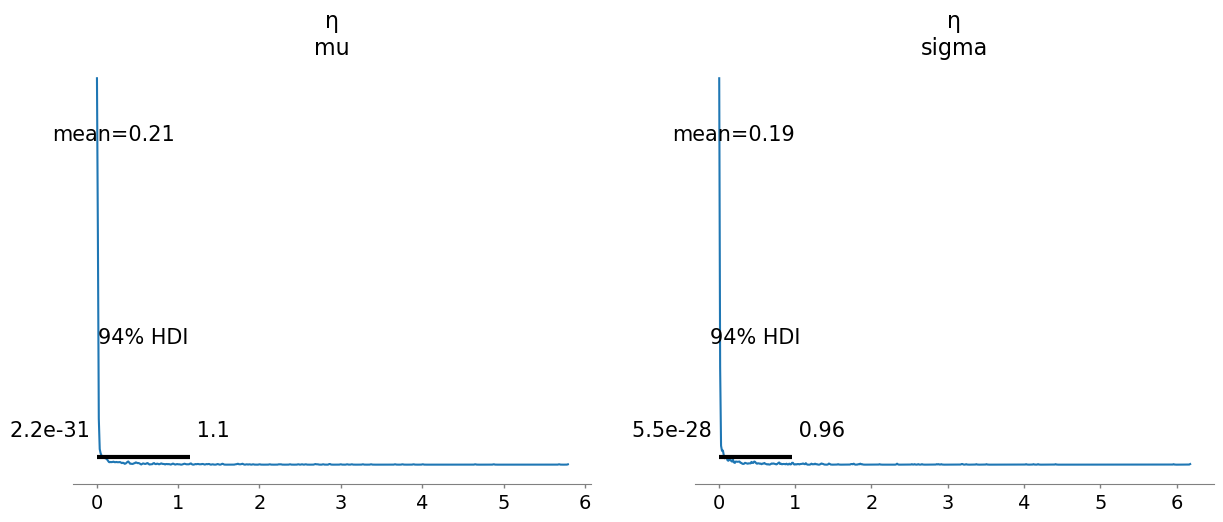

In [ ]:
gp_idata = pm.sample_prior_predictive(samples=1000, model=gp_model)
# az.plot_ppc(gp_idata, group="prior")

# ax.set_ylim([0, 2]);

az.plot_posterior(
    gp_idata, group="prior", var_names=["η"]
);
# ax = plt.gca()
# ax.set_xlim([0, 500])


In [ ]:
pm.Gamma.dist()

ValueError: Incompatible parameterization. Either use alpha and beta, or mu and sigma to specify distribution.